# Foveated ViTs and adapting pre-trained models (DINOv3)

Last, we will show how to build a foveated ViT with our code-base, walk through our approach to adapting pre-trained models, and load in our adapted foveated variant of DINOv3

Foveated ViTs are much simpler to build than foveated CNNs. In a foveated ViT, we simply modify the sensor and patch embedding, and then the architecture is a standard ViT!

Let's look at the patch embedding

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.cm as cm
import os 

In [2]:
def visualize_patch_embed(patch_embed):
    in_coords = patch_embed.in_coords
    out_coords = patch_embed.out_coords
    in_cart_coords = in_coords.cartesian.cpu().numpy()
    in_plotting_coords = in_coords.plotting.cpu().numpy()
    out_cart_coords = out_coords.cartesian.cpu().numpy()
    out_plotting_coords = out_coords.plotting.cpu().numpy()
    knns = patch_embed.knn_indices.cpu().numpy()

    cmap = cm.get_cmap('tab20b')
    alpha = 0.5
    rf_scalar = 0.01

    # plot output unit coordinates
    fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=800, gridspec_kw={'width_ratios': [2, 1]})
    axs[0].scatter(out_plotting_coords[:,0], out_plotting_coords[:,1], s=0.8, alpha=alpha)
    axs[1].scatter(out_cart_coords[:,0], out_cart_coords[:,1], s=0.8, alpha=alpha)
    rf_size = in_coords.polar[:,0].cpu().numpy()
    rf_size = rf_size + np.sort(rf_size)[1] # add second smallest value
    rf_size = rf_scalar*(rf_size / rf_size.min())

    # plot input kNNs
    for jj in range(knns.shape[1]):
        knn = knns[:,jj]
        mask = torch.logical_not(patch_embed.knn_indices_pad_mask[:,jj]).cpu()
        knn = knn[mask] # remove padding tokens
        np.random.seed(jj)
        color = cmap(np.random.randint(knns.shape[1]) / max(1, knns.shape[1] - 1))  # Normalize to [0,1] range
        axs[0].scatter(in_plotting_coords[knn,0], in_plotting_coords[knn,1], s=2, alpha=alpha, color=color, marker='o')
        axs[1].scatter(in_cart_coords[knn,0], in_cart_coords[knn,1], s=rf_size[knn], alpha=alpha, color=color, marker='o')
    
    for ax in axs:
        ax.axis('off')
        ax.axis('equal')
    axs[1].set_xlim(-1.1, 1.1)
    axs[1].set_ylim(-1.1, 1.1)

    plt.tight_layout()
    plt.show()

We will demonstrate three choices for patch embeddings. 

- **KNNPatchEmbedding**: this is the most direct translation of a KNNConv layer to the patch embedding setting. 
- **PartitioningPatchEmbedding**: this embedding yields a non-overlapping partition of the input coordinate space into output tokens. This produces some odd shapes around the boundaries. 
- **KNNPartitioningPatchEmbedding**: this uses the partitioning solution from a PartitioningPatchEmbedding to discover the minimum geodesic distance on the sensor manifold, and thereby $k$ value, needed for all input units to be assigned into output kNNs, producing slight overlap due to the circular nature of kNNs. We prefer this embedding due to the consistent patch shapes, and ease of parameterization relative to KNNPatchEmbedding. 




/home/nblauch/git/fovi/fovi/arch/knn.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_neighbors = torch.minimum(torch.tensor(self.k*m), torch.tensor(self.in_coords.shape[0]))
/home/nblauch/miniconda3/envs/fovi/lib/python3.9/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/nblauch/git/fovi/fovi/arch/knn.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_neighbors = torch.minimum(torch.tensor(self.k*m), torch.tensor(self.in_coords

minimum k to use all inputs: 117


/tmp/ipykernel_1306615/3433196042.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20b')


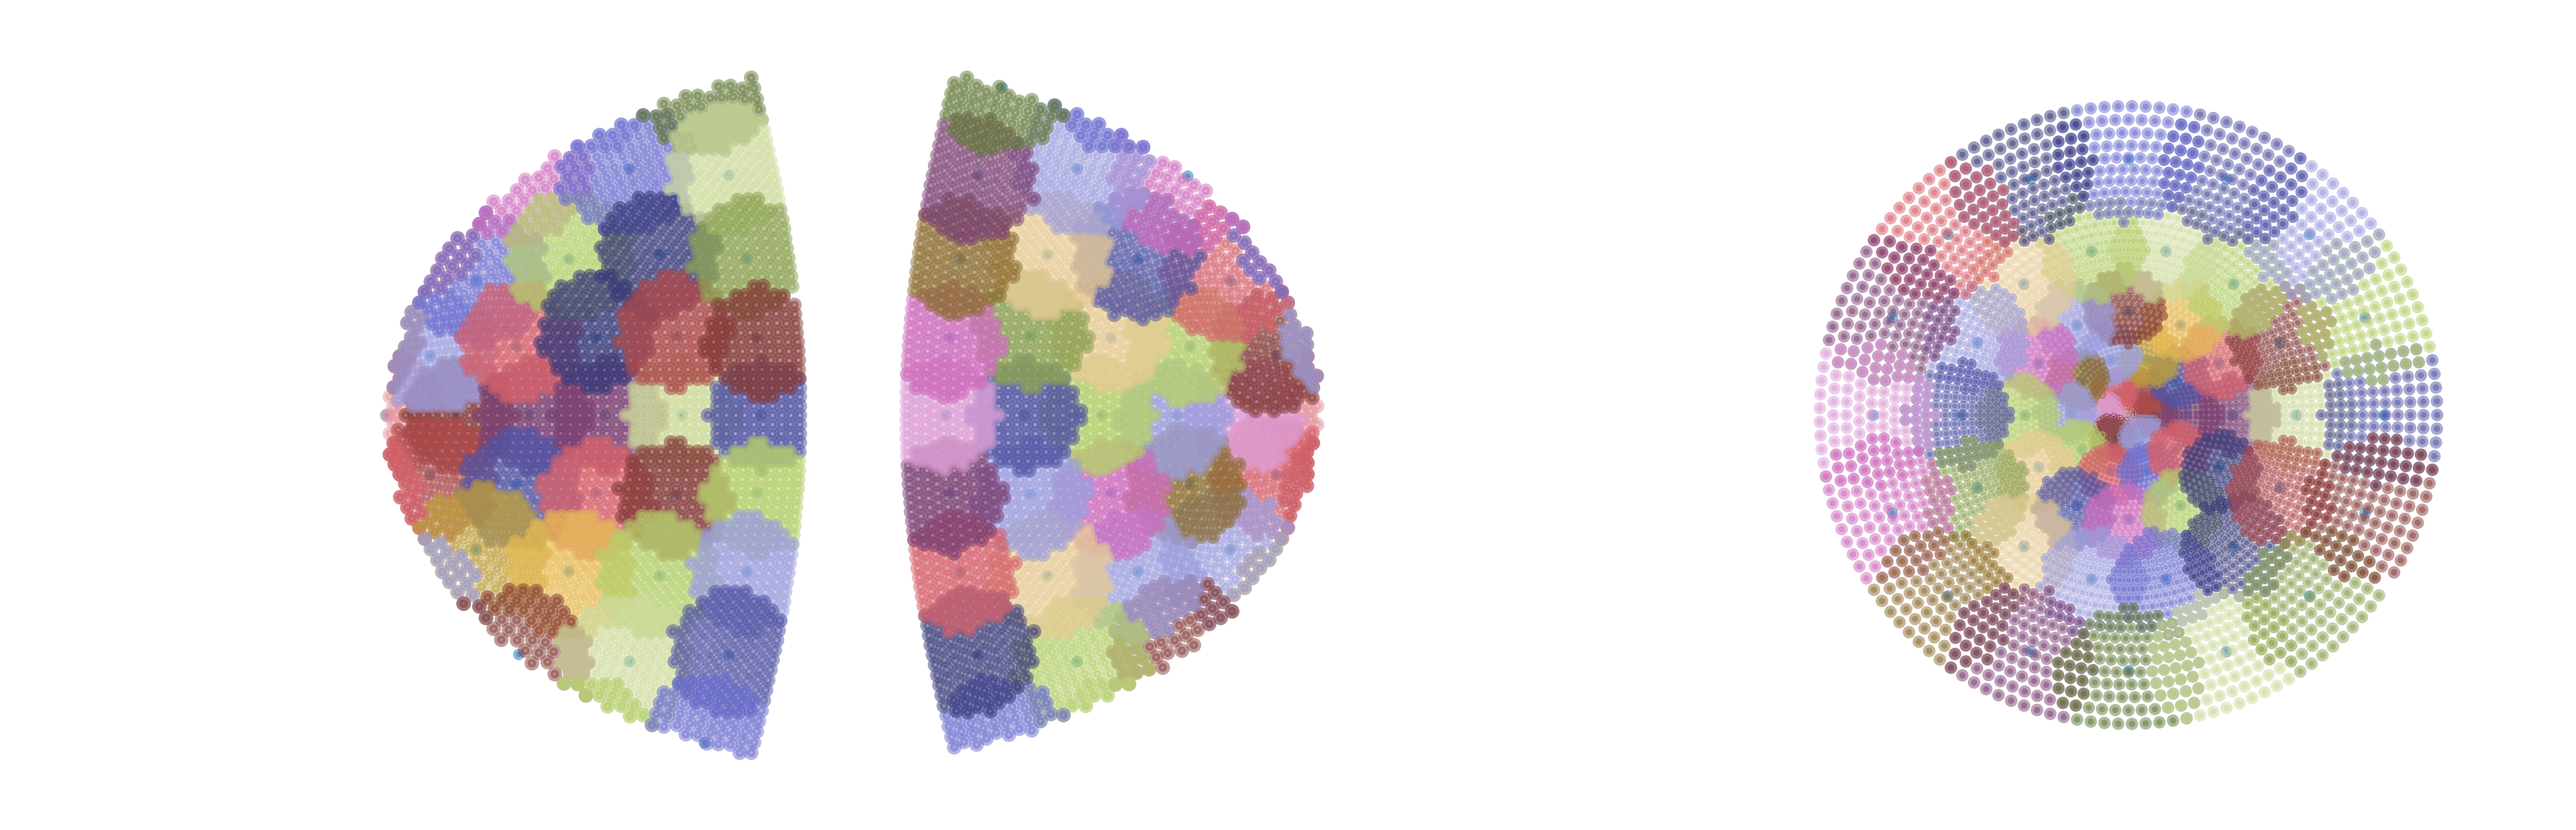

In [3]:
from fovi.arch.knnvit import KNNPartitioningPatchEmbedding

device = "cpu"
resolution = 64
fov = 16
cmf_a = 2

patch_embed = KNNPartitioningPatchEmbedding(
    3,
    384,
    resolution,
    fov,
    cmf_a,
    auto_match_cart_resources=1,
    in_cart_res=64,
    cart_patch_size=8,
    device=device,
    force_patches_less_than_matched=True,
    max_coord_val='auto',
    sample_cortex='geodesic',
)

visualize_patch_embed(patch_embed)


/home/nblauch/git/fovi/fovi/arch/knnvit.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.k = torch.tensor(max_len)
/tmp/ipykernel_1306615/3433196042.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20b')


minimum k to use all inputs: 81


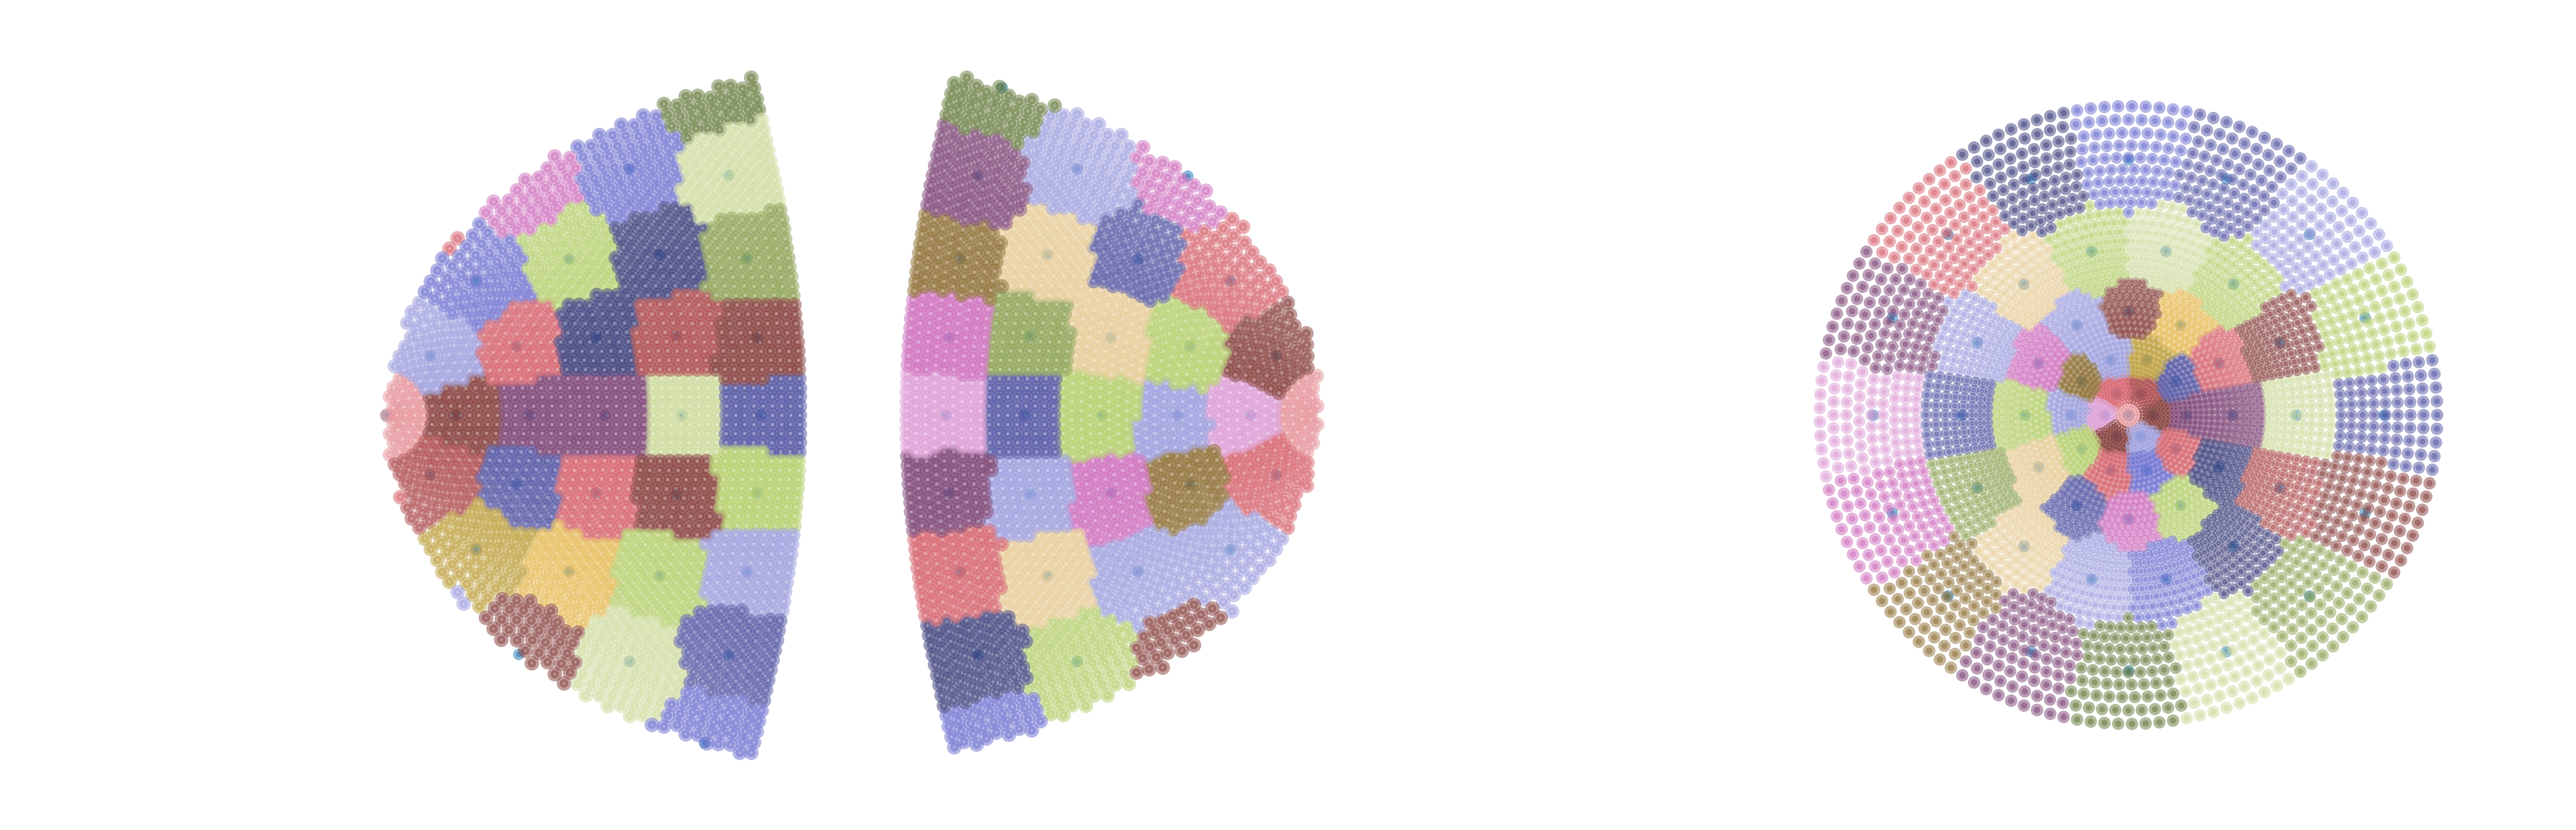

In [4]:
from fovi.arch.knnvit import PartitioningPatchEmbedding
alt_patch_embed = PartitioningPatchEmbedding(
    3,
    384,
    resolution,
    fov,
    cmf_a,
    auto_match_cart_resources=1,
    in_cart_res=64,
    cart_patch_size=8,
    device=device,
    force_patches_less_than_matched=True,
    max_coord_val='auto',
    sample_cortex='geodesic',
)

visualize_patch_embed(alt_patch_embed)

# load a pre-trained Foveated DINOv3

In [6]:
from fovi import get_model_from_base_fn

base_fn = 'fovi-dinov3-splus_a-2.78_res-64_in1k'
model = get_model_from_base_fn(base_fn)

Model with base_fn fovi-dinov3-splus_a-2.78_res-64_in1k not found in ../models
Attempting to download fovi-dinov3-splus_a-2.78_res-64_in1k from HuggingFace Hub...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Model with base_fn fovi-dinov3-splus_a-2.78_res-64_in1k downloaded from HuggingFace Hub to /home/nblauch/.cache/fovi/fovi-dinov3-splus_a-2.78_res-64_in1k
adjusting FOV for fixation: 16.0 (full: 16.0)
minimum k to use all inputs: 103
Note: horizontal flip always done in the loader, to avoid differences across fixations
Number of coords per layer: [3976, 64]
